In [32]:
# %%
import pandas as pd
import numpy as np
import time
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TFT
from statsforecast.core import StatsForecast
from neuralforecast.auto import AutoMLP, AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT, AutoDeepNPTS
from statsforecast.models import (
    Naive, SeasonalNaive, ARIMA, SimpleExponentialSmoothing, ETS,
    HistoricAverage, WindowAverage, AutoARIMA, AutoETS, AutoCES, AutoTheta
)
from mlforecast import MLForecast
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean
import plotly.graph_objects as go


In [33]:

# %%
# Define utility functions
def evaluate_forecast(y_true, y_pred):
    return np.sqrt(np.mean((y_true.values - y_pred.values) ** 2))

def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)) / 2)

def rmsse(y_true, y_pred, train):
    naive_forecast = np.roll(train, 1)
    naive_forecast[0] = train[0]
    scale = np.mean((train - naive_forecast) ** 2)
    return np.sqrt(np.mean((y_true - y_pred) ** 2) / scale)

def calculate_errors(test, forecasts, train):
    error_dict = {}
    for col in forecasts.columns:
        if col in ['ds', 'unique_id']:
            continue
        else:
            y_true = test['y'].values
            y_pred = forecasts[col].values
            error_dict.update({
                f'{col}_RMSE': evaluate_forecast(test['y'], forecasts[col]),
                f'{col}_SMAPE': smape(y_true, y_pred),
                f'{col}_RMSSE': rmsse(y_true, y_pred, train['y'].values)
            })
    return pd.DataFrame(error_dict, index=['Error'])

def run_forecast(forecaster, train, test_size, freq='ME', multi_origin=False, horizon_list=[1, 3, 6, 12]):
    if multi_origin:
        forecasts_list = []
        for horizon in horizon_list:
            start_time = time.time()
            forecasts_df = forecaster.forecast(df=train, h=horizon)
            train_time = time.time() - start_time
            forecasts_list.append(forecasts_df)
        return forecasts_list
    else:
        start_time = time.time()
        forecasts_df = forecaster.forecast(df=train, h=test_size)
        train_time = time.time() - start_time
        return forecasts_df, train_time


In [34]:

# %%
# Load and prepare data
from statsforecast.utils import AirPassengersDF

df = AirPassengersDF
test_size = 24
train_size = len(df) - test_size
train, test = df[:train_size], df[train_size:]

df.to_csv('Air_passengers.csv')


In [35]:

# %%
# Define models and parameters
basic_models = [
    Naive(),
    SeasonalNaive(12),
    ARIMA(order=[12, 1, 0]),
    ARIMA(order=[0, 1, 1], seasonal_order=[0, 1, 1], season_length=12, alias='SARIMA'),
    SimpleExponentialSmoothing(alpha=0.28),
    ETS(model='ZZZ', season_length=12),
    HistoricAverage(),
    WindowAverage(window_size=6)
]

auto_models = [
    AutoARIMA(max_p=12),
    AutoETS(season_length=12),
    AutoCES(season_length=12, alias='AutoCES'),
    AutoTheta(season_length=12)
]


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\models.py:880: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


In [36]:
@njit
def rolling_mean_12(x):
    return rolling_mean(x, window_size=12)


def month_index(times):
    return times.month


lgb_params = {'verbosity': -1, 'num_leaves': 512}
catboost_params = {'subsample': 0.6, 'iterations': 50, 'depth': 5, 'verbose': 0}
xgboost_params = {'verbosity': 0, 'max_depth': 5, 'subsample': 0.6}
randomforest_params = {'verbose': 0, 'max_depth': 5}

tree_models = {
    'LightGBM': lgb.LGBMRegressor(**lgb_params),
    'CatBoost': CatBoostRegressor(**catboost_params),
    'XgBoost': XGBRegressor(**xgboost_params),
    'RandomForest': RandomForestRegressor(**randomforest_params)
}


In [37]:
from ray import tune
neural_models = [
    NBEATS(input_size=2 * test_size, h=test_size, max_steps=50),
    NHITS(input_size=2 * test_size, h=test_size, max_steps=50),
    AutoMLP(config=dict(max_steps=50, input_size=tune.choice([3 * test_size]), learning_rate=tune.choice([1e-3])), h=test_size, num_samples=1, cpus=3),
    AutoNBEATS(config=dict(max_steps=50, input_size=tune.choice([3 * test_size]), learning_rate=tune.choice([1e-3])), h=test_size, num_samples=1, cpus=3),
    AutoNHITS(config=dict(max_steps=50, input_size=tune.choice([3 * test_size]), learning_rate=tune.choice([1e-3])), h=test_size, num_samples=1, cpus=3),
    AutoTFT(config=dict(max_steps=50, input_size=tune.choice([3 * test_size]), learning_rate=tune.choice([1e-3])), h=test_size, num_samples=1, cpus=3)
]


Seed set to 1
Seed set to 1
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [38]:

# %%
# Run forecasts and collect errors
error_dfs = []

# Basic models
forecasts_df, train_time = run_forecast(basic_models, {}, train, test_size)
error_non_auto = calculate_errors(test, forecasts_df, train)
error_non_auto['Train_Time'] = train_time
error_dfs.append(error_non_auto)


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [39]:

# Auto models
forecasts_df_auto, train_time = run_forecast(auto_models, {}, train, test_size)
error_auto = calculate_errors(test, forecasts_df_auto, train)
error_auto['Train_Time'] = train_time
error_dfs.append(error_auto)


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [40]:

# MLForecast with tree models
fcst = MLForecast(
    models=tree_models,
    freq="ME",
    target_transforms=[Differences([12])],
    lags=[1, 2, 3, 4, 11, 12],
    lag_transforms={1: [ExpandingMean()], 12: [RollingMean(window_size=12), rolling_mean_12]},
    date_features=[month_index]
)


In [41]:

start_time = time.time()
prep = fcst.preprocess(train)
fcst.fit(train)
forecasts_df_tree = fcst.predict(test_size)
train_time = time.time() - start_time

error_tree = calculate_errors(test, forecasts_df_tree, train)
error_tree['Train_Time'] = train_time
error_dfs.append(error_tree)


In [42]:

# NeuralForecast with neural models
nf = NeuralForecast(models=neural_models, freq='M')

start_time = time.time()
nf.fit(df=train)
forecasts_df_neural = nf.predict().reset_index()
train_time = time.time() - start_time

error_neural = calculate_errors(test, forecasts_df_neural, train)
error_neural['Train_Time'] = train_time
error_dfs.append(error_neural)


(_train_tune pid=9720) c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\ray\tune\integration\pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9720) Seed set to 1
(_train_tune pid=9720) c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
(_train_tune pid=9720)   warnings.warn("Initializing zero-element tensors is a no-op")
(_train_tune pid=9720) c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
(_train_tune pid=9720)   warnings.warn(
(_train_tune pid=9720) GPU available: False, used: False
(_train_tune pid=9720) TPU available: False, using: 0 TPU cores
(_train_tune pi

Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.220, train_loss_epoch=1.220]        


2024-07-06 14:55:14,525	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to 'C:/Users/91976/ray_results/_train_tune_2024-07-06_14-52-36' in 0.0141s.
(_train_tune pid=9720) `Trainer.fit` stopped: `max_steps=50` reached.
Seed set to 1
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type                     | Params
---------------------------------------------------------------------
0 | loss  

Epoch 49: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=0, train_loss_step=1.190, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:02<00:00,  0.34it/s, v_num=0, train_loss_step=1.190, train_loss_epoch=1.190, valid_loss=57.20]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\utilsforecast\processing.py:374: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\utilsforecast\processing.py:428: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [43]:

# TimeGPT
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(api_key='nixtla-tok-BWWtvgUP9FLtzerA90xyzXPvRUoZvA0OYYp5cuSI7NZUyApQjlINlF8dAyYXqDyxWlTlCOg7jXHWJV4o')

start_time = time.time()
forecasts_df_timegpt = nixtla_client.forecast(df=train, h=test_size, freq='M', time_col='ds', target_col='y')
train_time = time.time() - start_time

error_timegpt = calculate_errors(test, forecasts_df_timegpt, train)
error_timegpt['Train_Time'] = train_time
error_dfs.append(error_timegpt)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: ME
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


                   Model       Error
0          AutoCES_RMSSE    0.468213
1          TimeGPT_RMSSE    0.468601
2         LightGBM_RMSSE    0.483276
3          XgBoost_RMSSE    0.512230
4     RandomForest_RMSSE    0.525468
..                   ...         ...
69        AutoARIMA_RMSE   84.498827
70              SES_RMSE   91.367998
71            Naive_RMSE  102.976535
72  HistoricAverage_RMSE  226.265665
73            Train_Time  400.459923

[74 rows x 2 columns]


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:1386: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:1386: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



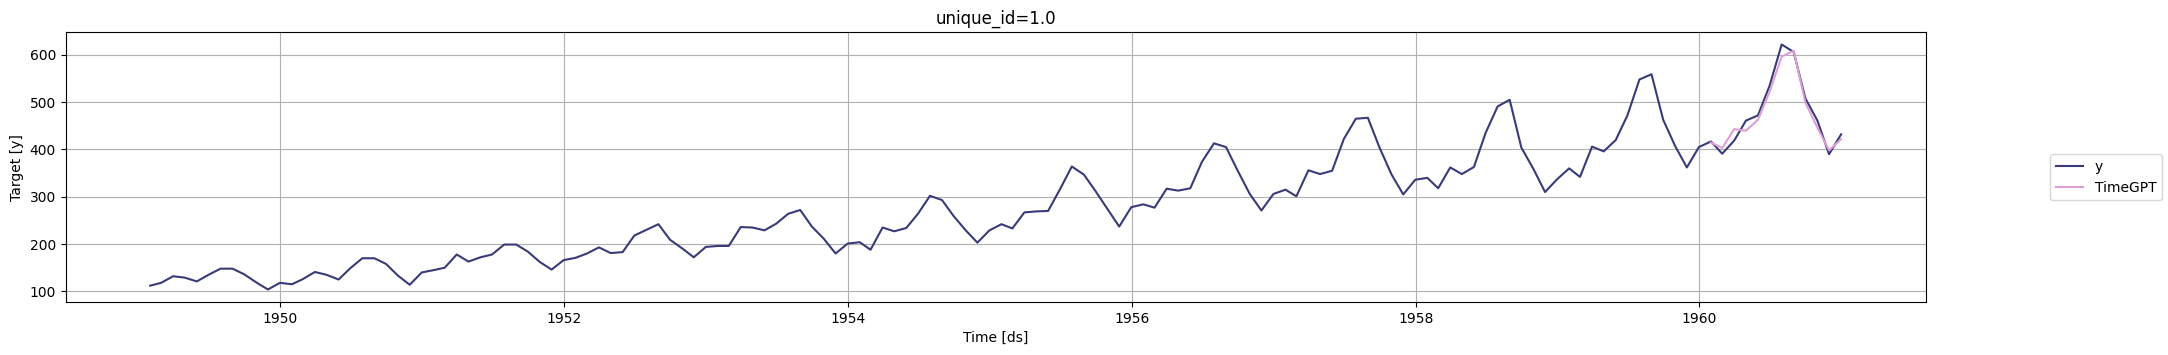

In [44]:

# %%
# Combine and sort errors
combined_df = pd.concat(error_dfs, ignore_index=True)
sorted_df = combined_df.melt(var_name='Model', value_name='Error').dropna().sort_values(by='Error')
sorted_df.reset_index(drop=True, inplace=True)
print(sorted_df)

# %%
# Plot results
StatsForecast.plot(df, forecasts_df, engine='plotly')
StatsForecast.plot(df, forecasts_df_auto, engine='plotly')
StatsForecast.plot(df, forecasts_df_tree.reset_index())
StatsForecast.plot(df, forecasts_df_neural, engine='plotly')
StatsForecast.plot(df, forecasts_df_timegpt)

In [45]:
sorted_df

,Model,Error
0,AutoCES_RMSSE,0.468213
1,TimeGPT_RMSSE,0.468601
2,LightGBM_RMSSE,0.483276
3,XgBoost_RMSSE,0.512230
4,RandomForest_RMSSE,0.525468
...,...,...
69,AutoARIMA_RMSE,84.498827
70,SES_RMSE,91.367998
71,Naive_RMSE,102.976535
72,HistoricAverage_RMSE,226.265665
